In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from wordcloud import WordCloud, STOPWORDS
import folium
from folium import Choropleth, Circle, Marker
from folium.plugins import HeatMap, MarkerCluster

import warnings
warnings.filterwarnings('ignore')

In [2]:
data = pd.read_csv('airbnb/listings_march16_2023.csv')

In [3]:
# df.drop(['listing_url','scrape_id','source'], axis=1, inplace=True)
# mask1 = ['id', 'host_id', 'host_listings_count', 'host_total_listings_count','neighbourhood_cleansed', 'latitude', 'longitude', 'price','number_of_reviews','review_scores_cleanliness','reviews_per_month' ]
mask1 = ['id', 
         'host_id',
         'neighbourhood_cleansed',
         'host_neighbourhood',
         'property_type',
         'price',
         'latitude', 
         'longitude', 
         'number_of_reviews',
         'review_scores_rating',
         'review_scores_accuracy',
         'reviews_per_month']

In [4]:
df = data[mask1]
df = df.rename(columns={'neighbourhood_cleansed':"neighborhood"})
df.head()

,id,host_id,neighborhood,host_neighbourhood,property_type,price,latitude,longitude,number_of_reviews,review_scores_rating,review_scores_accuracy,reviews_per_month
0,5456,8028,78702,East Downtown,Entire guesthouse,$176.00,30.26057,-97.73441,630,4.84,4.88,3.69
1,5769,8186,78729,SW Williamson Co.,Private room in home,$42.00,30.45697,-97.78422,275,4.90,4.90,1.75
2,6413,13879,78704,Travis Heights,Entire guesthouse,$109.00,30.24885,-97.73587,122,4.97,4.99,0.76
3,6448,14156,78704,Zilker,Entire guesthouse,$240.00,30.26034,-97.76487,295,4.97,4.97,2.10
4,8502,25298,78741,East Riverside,Entire guest suite,$85.00,30.23466,-97.73682,48,4.53,4.49,0.30


In [45]:
df.shape

(14368, 10)

In [46]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14368 entries, 0 to 14367
Data columns (total 10 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   id                      14368 non-null  int64  
 1   host_id                 14368 non-null  int64  
 2   neighborhood            14368 non-null  int64  
 3   latitude                14368 non-null  float64
 4   longitude               14368 non-null  float64
 5   price                   14368 non-null  object 
 6   number_of_reviews       14368 non-null  int64  
 7   review_scores_rating    11337 non-null  float64
 8   review_scores_accuracy  11269 non-null  float64
 9   reviews_per_month       11337 non-null  float64
dtypes: float64(5), int64(4), object(1)
memory usage: 1.1+ MB


In [47]:
df.isna().sum()

id                           0
host_id                      0
neighborhood                 0
latitude                     0
longitude                    0
price                        0
number_of_reviews            0
review_scores_rating      3031
review_scores_accuracy    3099
reviews_per_month         3031
dtype: int64

In [5]:
df.price = df.price.astype('str')
df['price'] = df.price.str.replace('$','', regex=True).replace(',','',regex=True)
df.price = df.price.astype(float)
df.price = df.price.astype(int)

In [50]:
df.price.dtype

dtype('int32')

In [51]:
df.describe()

,id,host_id,neighborhood,latitude,longitude,price,number_of_reviews,review_scores_rating,review_scores_accuracy,reviews_per_month
count,1.436800e+04,1.436800e+04,14368.000000,14368.000000,14368.000000,14368.000000,14368.000000,11337.000000,11269.000000,11337.000000
mean,2.694267e+17,1.362267e+08,78724.538001,30.280983,-97.750141,310.029928,35.700237,4.786868,4.842808,1.558955
std,3.495810e+17,1.507129e+08,20.698788,0.064400,0.062632,798.368170,77.234472,0.521385,0.362509,1.748971
min,5.456000e+03,2.300000e+01,78701.000000,30.078870,-98.056630,0.000000,0.000000,0.000000,1.000000,0.010000
25%,2.332972e+07,1.584240e+07,78704.000000,30.241967,-97.769393,108.000000,1.000000,4.770000,4.830000,0.270000
50%,4.979213e+07,6.633146e+07,78723.000000,30.268635,-97.740720,180.000000,8.000000,4.930000,4.950000,1.000000
75%,6.762467e+17,2.361955e+08,78745.000000,30.309180,-97.717148,320.000000,33.000000,5.000000,5.000000,2.270000
max,8.473047e+17,5.051848e+08,78759.000000,30.512250,-97.560620,65155.000000,1099.000000,5.000000,5.000000,29.110000


In [21]:
quant = df.price.quantile([0.25,0.75])
q1, q3 = quant[0.25], quant[0.75]
print(q1,q3)
IQR = q3-q1
low  = q1-1.5*IQR
high = q3+1.5*IQR
print(low,high)

108.0 320.0
-210.0 638.0


In [30]:
df = df[df.price!=0]
df

,id,host_id,neighbourhood,latitude,longitude,price,number_of_reviews,review_scores_accuracy,reviews_per_month
0,5456,8028,78702,30.260570,-97.734410,176,630,4.88,3.69
1,5769,8186,78729,30.456970,-97.784220,42,275,4.90,1.75
2,6413,13879,78704,30.248850,-97.735870,109,122,4.99,0.76
3,6448,14156,78704,30.260340,-97.764870,240,295,4.97,2.10
4,8502,25298,78741,30.234660,-97.736820,85,48,4.49,0.30
...,...,...,...,...,...,...,...,...,...
14363,847159076072987428,276920863,78705,30.289220,-97.747269,129,0,NaN,NaN
14364,847171709264672413,276920863,78705,30.290238,-97.748501,54,0,NaN,NaN
14365,847178203609366885,276920863,78705,30.287227,-97.726643,145,0,NaN,NaN
14366,847256590826352221,499116561,78734,30.381710,-97.952860,144,0,NaN,NaN


In [43]:
df[df.duplicated(['host_id'])].count()

id                        5743
host_id                   5743
neighborhood              5743
host_neighbourhood        5353
property_type             5743
price                     5743
latitude                  5743
longitude                 5743
number_of_reviews         5743
review_scores_rating      4426
review_scores_accuracy    4419
reviews_per_month         4426
dtype: int64

In [63]:
df.property_type.unique()

array(['Entire guesthouse', 'Private room in home', 'Entire guest suite',
       'Entire home', 'Entire bungalow', 'Entire condo',
       'Entire townhouse', 'Entire rental unit',
       'Private room in bed and breakfast', 'Private room in loft',
       'Private room', 'Entire loft', 'Private room in guest suite',
       'Private room in cabin', 'Private room in bungalow',
       'Entire cottage', 'Private room in rental unit',
       'Private room in condo', 'Campsite', 'Entire cabin',
       'Entire villa', 'Camper/RV', 'Entire place',
       'Private room in guesthouse', 'Tiny home', 'Boat',
       'Shared room in home', 'Private room in townhouse',
       'Private room in tiny home', 'Tent', 'Shared room',
       'Shared room in rental unit', 'Bus', 'Entire serviced apartment',
       'Shared room in townhouse', 'Shared room in loft',
       'Private room in tent', 'Treehouse', 'Private room in camper/rv',
       'Tipi', 'Shared room in camper/rv', 'Barn',
       'Room in boutique

,id,host_id,neighborhood,host_neighbourhood,property_type,latitude,longitude,price,number_of_reviews,review_scores_rating,review_scores_accuracy,reviews_per_month
5,13035,50793,78702,East Downtown,Entire home,30.260980,-97.730720,160,17,5.00,4.94,0.12
6,18258,39458,78745,NaN,Entire bungalow,30.197560,-97.787540,171,2,5.00,5.00,0.42
9,23496,8028,78702,East Downtown,Entire home,30.251230,-97.704630,200,0,NaN,NaN,NaN
10,25028,102862,78757,Brentwood,Entire bungalow,30.337710,-97.737080,221,35,4.94,5.00,0.22
11,40285,170787,78731,Northwest Hills,Entire home,30.351230,-97.762070,450,37,4.92,4.94,0.25
...,...,...,...,...,...,...,...,...,...,...,...,...
14348,846270360068150227,36957600,78751,North Loop,Entire home,30.318651,-97.717884,200,0,NaN,NaN,NaN
14349,846333376293351069,184129060,78704,Bouldin Creek,Entire home,30.250366,-97.756824,720,0,NaN,NaN,NaN
14350,846354824679406454,118565935,78704,Blackshear-Prospect Hill,Entire home,30.240146,-97.756756,422,0,NaN,NaN,NaN
14351,846407290756228021,213599362,78702,Govalle,Entire home,30.253073,-97.709899,1193,0,NaN,NaN,NaN


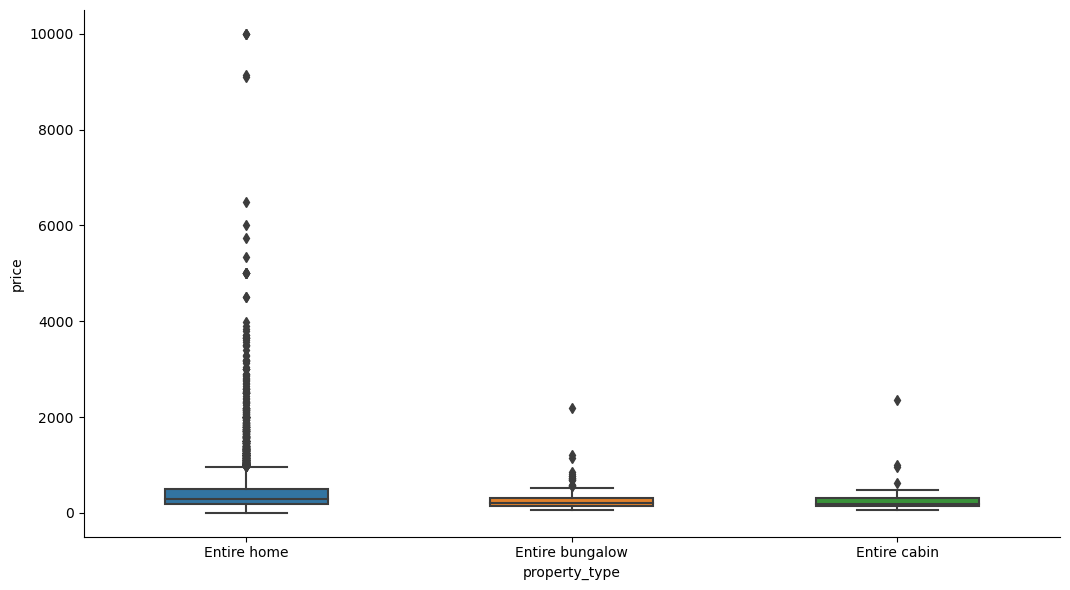

In [76]:
xx = df[df["property_type"].isin(['Entire home', 'Entire bungalow', 'Entire cabin'])]
sns.catplot(
    data=xx, 
    x='property_type', y='price', kind='box',
    height=6, aspect=1.8, width=0.5
)
xx

In [59]:
df = df[df.price>0]

In [90]:
df.groupby('host_neighbourhood')['price'].agg(['count','sum']).sort_values(by='count',ascending=False)

,count,sum
host_neighbourhood,,
East Downtown,615,254795
South Austin,510,107225
South Lamar,483,96713
East Riverside - Oltorf,361,91356
Zilker,322,155295
...,...,...
Mission Valley East,1,295
Mission Beach,1,224
Miramonte,1,100


In [113]:
# df["Period"] = df['Courses'].astype(str) +"-"+ df["Duration"]


df['longitude'] = df['longitude'].astype(str)
df['latitude'] = df['latitude'].astype(str)
df['latlong'] = df['latitude'].astype(str)+','+df['longitude']

In [83]:
df.host_neighbourhood.unique()

array(['East Downtown', 'SW Williamson Co.', 'Travis Heights', 'Zilker',
       'East Riverside', nan, 'Clarksville', 'Brentwood',
       'Northwest Hills', 'West Campus', 'Dawson', 'Galindo',
       'South Congress', 'Rosedale', 'Angus Valley', 'South Lamar',
       'Tarrytown', 'Upper Boggy Creek', 'Holly', 'Downtown', 'MLK & 183',
       'Barton Hills', 'Windsor Park', 'Highland', 'Wooten',
       'Cherry Creek', 'Hyde Park', 'University of Texas', 'Rollingwood',
       'Govalle', 'Bouldin Creek', 'Cesar Chavez', 'St. Edwards',
       'Rosewood', 'West Congress', 'East Congress', 'Long Canyon',
       'South Manchaca', 'Allendale', 'Westlake Hills', 'South First',
       'Riverside Heights', 'Old Enfield', 'Hancock', 'Old West Austin',
       'North Loop', 'Greater South River City', 'North Shoal Creek',
       'Pecan Spings', 'Cherrywood', 'Balcones Civic Association',
       'Mueller', 'McKinney', 'West Oak Hill', 'Pleasant Valley',
       'St. Johns', 'Copperfield', 'Parker Lane'

<AxesSubplot:xlabel='number_of_reviews', ylabel='price'>

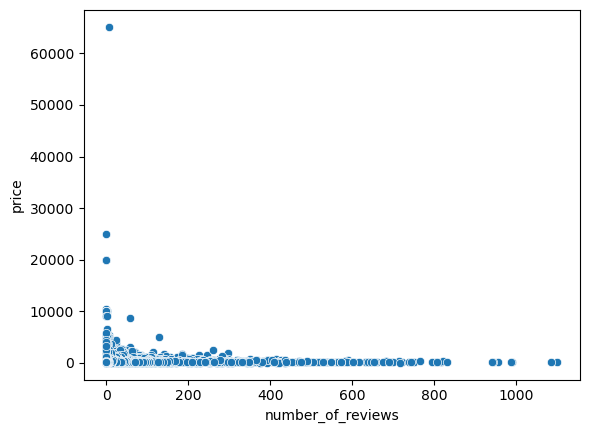

In [53]:
sns.scatterplot(x='number_of_reviews', y="price", data=df)

In [44]:
x = df[df.duplicated(['latitude','longitude','host_id'],keep=False)].sort_values(by='host_id')
x

,id,host_id,neighborhood,host_neighbourhood,property_type,price,latitude,longitude,number_of_reviews,review_scores_rating,review_scores_accuracy,reviews_per_month
8478,53124778,500739,78752,St. Johns,Private room in home,101,30.335878,-97.704567,29,5.00,5.00,2.20
8605,53559921,500739,78752,St. Johns,Private room in home,98,30.335878,-97.704567,21,5.00,5.00,1.59
650,2832087,579290,78704,Barton Hills,Entire home,161,30.245580,-97.785110,62,4.74,4.75,0.66
1210,5806636,579290,78704,Barton Hills,Entire home,149,30.244110,-97.738580,78,4.86,4.88,0.82
3019,20406990,579290,78704,Barton Hills,Entire home,170,30.244220,-97.772930,33,4.91,4.85,0.52
...,...,...,...,...,...,...,...,...,...,...,...,...
11519,714176398774488809,475533011,78701,Downtown Austin,Private room in resort,941,30.271598,-97.747574,0,NaN,NaN,NaN
11520,714176563692740834,475533011,78701,Downtown Austin,Private room in resort,635,30.271598,-97.747574,0,NaN,NaN,NaN
11521,714176725548700141,475533011,78701,Downtown Austin,Private room in resort,635,30.271598,-97.747574,0,NaN,NaN,NaN
11523,714177050367442411,475533011,78701,Downtown Austin,Private room in resort,635,30.271598,-97.747574,0,NaN,NaN,NaN
